# Библиотеки

In [ ]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

# Matplotlib и plotly
import matplotlib.pyplot as plt
import plotly.express as px

# cv2
import cv2

# OS
import os
import argparse
from tqdm.auto import tqdm

import random
from typing import Dict, List, Optional, Tuple
from IPython.display import clear_output

# Модель

In [ ]:
train_dataset = CIFAR10(root="./", train=True, download=True)
test_dataset = CIFAR10(root="./", train=False, download=True)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


In [ ]:
TITLE_FONT_SIZE = 16

def prepare_images(train_data: np.ndarray, test_data: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
    train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
    train_data = train_data / 255.0
    train_data = np.expand_dims(train_data, axis=3)
    train_data = np.transpose(train_data, (0, 3, 1, 2))

    if test_data is not None:
        train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
        test_data = test_data / 255.0
        train_data = np.expand_dims(train_data, axis=3)
        test_data = np.transpose(test_data, (0, 3, 1, 2))
        return train_data, test_data

    return train_data

def load_CIFAR10(
    with_targets: bool = False, is_train=True,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    dataset = CIFAR10(root="./", train=is_train, download=False)
    data = dataset.data

    if with_targets:
        labels = np.array(dataset.targets)
        return data, labels

    return data

def load_dataset(
    is_train: bool = True,
    classes: Optional[List[int]] = None,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    data, labels = load_CIFAR10(with_targets=True, is_train=is_train)
    data = data.astype("float32")

    data = prepare_images(data)

    if classes is not None:
        mask = np.isin(labels, classes)
        data = data[mask]

    return data

def show_samples(
    samples: np.ndarray,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)
    samples = samples.float()
    if (samples > 1).any():
        samples /= 255
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)

    grid_img = grid_img.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

In [ ]:
from typing import Dict, Optional, Tuple, Union

from matplotlib.axes import Axes
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    precision_score,
    recall_score,
    roc_auc_score,
)

def _plot_precision_and_recall_curves(
    y_true: Union[pd.Series, np.ndarray], y_score: Union[pd.Series, np.ndarray], ax: Optional[Axes] = None
) -> None:
    """Метод по отрисовке графиков Precision, Recall и mean_prediction в зависимости от пороговых значений для скора

    Args:
        y_true: фактические метки классов тестовой выборки
        y_score: посчитанные скоры для тестовой выборки
        ax: объект класса Axes для отрисовки графика
    """
    if ax is None:
        _, ax = plt.subplots()

    thresholds = np.linspace(0.01, 0.99, 200)

    precision = []
    recall = []
    proportion = []
    for threshold in thresholds:
        threshold_preds = (y_score > threshold).astype(int)
        precision.append(precision_score(y_true, threshold_preds, zero_division=0))
        recall.append(recall_score(y_true, threshold_preds, zero_division=0))
        proportion.append(threshold_preds.mean())
        # if y_true.mean() / threshold_preds.mean() <= 1:
        #     proportion.append(y_true.mean() / threshold_preds.mean())

    ax.plot(thresholds, precision, "-r", label="precision")
    ax.plot(thresholds, recall, "-.b", label="recall")
    ax.plot(thresholds[: len(proportion)], proportion, "--g", label="mean prediction")

    major_ticks = np.arange(0, 1.1, 0.1)
    minor_ticks = np.arange(0.05, 1, 0.1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    ax.grid(which="both", axis="both", visible=True)
    ax.grid(which="minor", alpha=0.2)
    ax.grid(which="major", alpha=0.5)

    ax.set_xlabel("threshold")
    ax.set_ylabel("metrics")
    ax.set_title("Precision and Recall curves")
    ax.legend(
        fontsize=8.5,
        title="",
        frameon=False,
        bbox_to_anchor=(0, -1.15, 1, 1),
        loc="upper center",
        mode="expand",
        ncol=3,
    )

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, layer_config, layer_type='linear', latent_dim=256):
        """
        Автоэнкодер с кастомной архитектурой

        Параметры:
            input_dim (int или tuple): Размер входных данных (для линейных слоёв - int,
                                      для свёрточных - (channels, height, width))
            layer_config (list): Конфигурация слоёв (например, [128, 64, 32] для энкодера)
            layer_type (str): Тип слоёв ('linear' или 'conv')
            latent_dim (int): Размер латентного пространства
        """
        super(Autoencoder, self).__init__()
        self.layer_type = layer_type
        self.latent_dim = latent_dim
        self.encoder = self._build_encoder(input_dim, layer_config)
        self.decoder = self._build_decoder(input_dim, layer_config[::-1])

    def _build_encoder(self, input_dim, layer_config):
        layers = nn.ModuleList()

        if self.layer_type == 'linear':
            # Линейные слои
            prev_dim = input_dim
            for dim in layer_config:
                layers.append(nn.Linear(prev_dim, dim))
                layers.append(nn.ReLU())
                prev_dim = dim
            layers.append(nn.Linear(prev_dim, self.latent_dim))
            layers.append(nn.ReLU())

        elif self.layer_type == 'conv':
            # Свёрточные слои
            channels, h, w = input_dim
            prev_channels = channels
            for out_channels in layer_config:
                layers.append(nn.Conv2d(prev_channels, out_channels, kernel_size=3, stride=2, padding=1))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
                prev_channels = out_channels
                h = h // 2
                w = w // 2
            layers.append(nn.Flatten())
            self.encoder_output_dim = prev_channels * h * w
            layers.append(nn.Linear(self.encoder_output_dim, self.latent_dim))

        return nn.Sequential(*layers)

    def _build_decoder(self, input_dim, layer_config):
        layers = nn.ModuleList()

        if self.layer_type == 'linear':
            if len(layer_config) > 0:
                layers.append(nn.Linear(self.latent_dim, layer_config[0]))
                layers.append(nn.ReLU())

                prev_dim = layer_config[0]
                for dim in layer_config[1:]:
                    layers.append(nn.Linear(prev_dim, dim))
                    layers.append(nn.ReLU())
                    prev_dim = dim
            else:
                prev_dim = self.latent_dim
            layers.append(nn.Linear(prev_dim, input_dim))
            layers.append(nn.Sigmoid())

        elif self.layer_type == 'conv':
            channels, h, w = input_dim
            encoder_final_h = h // (2 ** len(layer_config))
            encoder_final_w = w // (2 ** len(layer_config))
            encoder_final_channels = layer_config[-1] if len(layer_config) > 0 else channels

            layers.append(nn.Linear(self.latent_dim, encoder_final_channels * encoder_final_h * encoder_final_w))
            layers.append(nn.Unflatten(1, (encoder_final_channels, encoder_final_h, encoder_final_w)))

            prev_channels = encoder_final_channels
            for out_channels in layer_config:
                layers.append(nn.ConvTranspose2d(prev_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
                prev_channels = out_channels

            layers.append(nn.ConvTranspose2d(prev_channels, channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.Sigmoid())

        return nn.Sequential(*layers)

    def forward(self, x):
        if self.layer_type == 'linear':
            x = x.view(-1, 1024)

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        if self.layer_type == 'linear':
            decoded = decoded.view(-1, 1, 32, 32)
        return decoded

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Дополнительные функции

In [ ]:
def sample_data(data: np.ndarray, num_elements: int) -> np.ndarray:
    random_indices = np.random.choice(data.shape[0], num_elements, replace=False)
    return data[random_indices]

def get_data_mix(
    class_1_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
    class3_proportion: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray]:
    num_base_samples = int(num_samples * (1 - class3_proportion))
    num_class3_samples = num_samples - num_base_samples

    train_1_data = sample_data(class_1_data, num_base_samples)
    train_3_data = sample_data(class_3_data, num_class3_samples)

    train_data = np.concatenate([train_1_data, train_3_data])

    return train_data

In [ ]:
def extract_singular_values_from_layer(weight_tensor):
    if len(weight_tensor.shape) == 4:
        out_channels, in_channels, kernel_height, kernel_width = weight_tensor.shape
    else:
        out_channels, in_channels = weight_tensor.shape
    weight_matrix = weight_tensor.reshape(out_channels, -1)

    U, S, Vt = np.linalg.svd(weight_matrix)
    S = S / np.sum(S)
    return S

def extract_singular_values_from_encoder(weights, num_values=None):
    singular_values_list = []
    for layer_weights in weights:
        singular_values = extract_singular_values_from_layer(layer_weights)
        if num_values is not None:
            singular_values = singular_values[:num_values]
        singular_values_list.append(singular_values)
    return singular_values_list

def get_vector(model, num_values=None):
    model.eval()
    weights = []
    with torch.no_grad():
      for layer in model.encoder:  # [model.encoder]
          if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
              weights.append(layer.weight.data.cpu().numpy())
      for layer in model.decoder:  # [model.decoder]
          if isinstance(layer, nn.ConvTranspose2d) or isinstance(layer, nn.Linear):
              weights.append(layer.weight.data.cpu().numpy())
      singular_values_list = extract_singular_values_from_encoder(weights, num_values=num_values)
    return np.concatenate(singular_values_list)

# MSE, таргет -- доли классов в датасете

In [ ]:
def train_model(model, train_loader, num_epochs):
    model.to(device)
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for inputs_list in train_loader:
            inputs = inputs_list[0]

            # ============ Forward ============
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

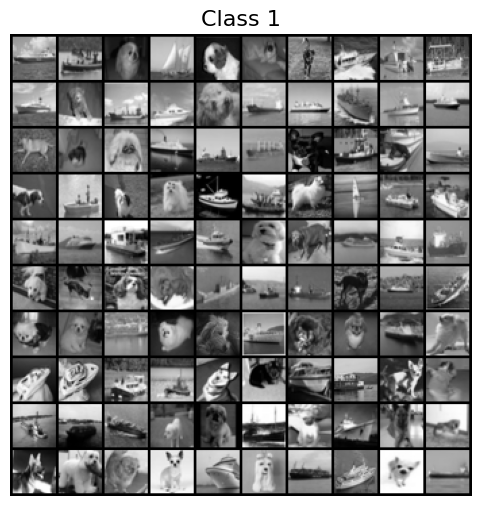

In [ ]:
INPUT_DIM = 1024
HIDDEN_DIM = 256

NUM_LAYERS = 0
# layer_configs = [[HIDDEN_DIM] * i for i in range(NUM_LAYERS)]
# layer_configs = [[HIDDEN_DIM] * NUM_LAYERS]
layer_configs = [[]]

num_models_train = 300
num_models_test = 100
NUM_EPOCHS = 20
BATCH_SIZE = 32

PROPORTION = 0.8
NUM_SAMPLES = 2000
INFO_PART = 0.8

classes = [5, 6, 8]

class_1_data = load_dataset(is_train=True, classes=classes[0])
class_2_data = load_dataset(is_train=True, classes=classes[1])
class_3_data = load_dataset(is_train=True, classes=classes[2])

train_data = get_data_mix(class_1_data, class_3_data, num_samples=2000, class3_proportion=0.5)
visualize_images(train_data, "Class 1")

In [ ]:
def find_top_percent(arr, part):
    sorted_arr = np.sort(arr)[::-1]
    cumulative_sum = np.cumsum(sorted_arr)
    total_sum = np.sum(arr)

    # Находим минимальное n, где cumulative_sum >= part * total_sum
    n = np.argmax(cumulative_sum >= part * total_sum) + 1  # +1 т.к. индексация с 0
    return n

def keep_n_values(arr, n):
    sorted_arr = np.sort(arr)[::-1]
    min_value = sorted_arr[n - 1]
    result = arr[arr >= min_value][:n]
    return result

def train_models(
    num_models,
    data_1,
    data_2,
    layer_config,
    proportion,
    config_path,
    model_class,
    mode="train",
    vector_dim=0
):
    vectors = []
    new_vectors = []
    metadata = []
    for i in tqdm(range(num_models)):
        train_data_np = get_data_mix(data_1, data_2, num_samples=NUM_SAMPLES, class3_proportion=PROPORTION)
        # train_data_np = get_data_equal(data_1, data_2, num_samples=2000)
        train_data_tensor = torch.tensor(train_data_np).float().to(device)
        train_dataset_tensor = TensorDataset(train_data_tensor)
        train_loader = DataLoader(train_dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

        model = Autoencoder(INPUT_DIM, layer_config, layer_type="linear", latent_dim=HIDDEN_DIM)
        trained_model = train_model(model, train_loader, NUM_EPOCHS)

        # vector = get_vector(trained_model, num_values=512 // (NUM_LAYERS + 1))
        vector = get_vector(trained_model)

        if vector_dim == 0:
            vector_dim = find_top_percent(vector, INFO_PART)
            print(vector_dim)
        new_vector = keep_n_values(vector, vector_dim)
        vectors.append(vector)
        new_vectors.append(new_vector)

        model_path = os.path.join(config_path, mode, f"model_{model_class}_{i}.pt")
        torch.save(trained_model.state_dict(), model_path)

        metadata.append({
            "model_id": model_class * num_models + i,
            "path": f"{mode}/model_{model_class}_{i}.pt"
        })
    return vectors, new_vectors, metadata, vector_dim

In [ ]:
import json

def create_folder_structure(base_dir, configs):
    for config in configs:
        config_name = f"{len(config) + 1}_layers"
        config_path = os.path.join(base_dir, config_name)
        os.makedirs(os.path.join(config_path, "train"), exist_ok=True)
        os.makedirs(os.path.join(config_path, "test"), exist_ok=True)
        print(f"Created folder structure for {config_name}")

base_dir = "layers"
create_folder_structure(base_dir, layer_configs)

for layer_config in layer_configs:
    config_name = f"{len(layer_config) + 1}_layers"
    print(f"\n=== Processing configuration: {config_name} ===")
    config_path = os.path.join(base_dir, config_name)

    # Метаданные эксперимента
    metadata = {
        "input_dim": INPUT_DIM,
        "latent_dim": HIDDEN_DIM,
        "layer_config": layer_config,
        "train_models": [],
        "test_models": []
    }
    vector_dim = 0

    for model_class in [0, 1]:
        print(f"Training {num_models_train} train models, class {model_class}...")
        if model_class == 0:
            base_data = class_1_data
        else:
            base_data = class_2_data

        vectors, new_vectors, metadata_add, vector_dim = train_models(
            num_models_train,
            base_data,
            class_3_data,
            layer_config,
            PROPORTION,
            config_path,
            model_class,
            vector_dim=vector_dim
        )
        metadata["train_models"].extend(metadata_add)
        np.save(os.path.join(config_path, "train", f"vectors_{model_class}.npy"), vectors)
        np.save(os.path.join(config_path, "train", f"vectors_new_{model_class}.npy"), new_vectors)

    for model_class in [0, 1]:
        print(f"Training {num_models_test} test models, class {model_class}...")
        if model_class == 0:
            base_data = class_1_data
        else:
            base_data = class_2_data

        vectors, new_vectors, metadata_add, _ = train_models(
            num_models_test,
            base_data,
            class_3_data,
            layer_config,
            PROPORTION,
            config_path,
            model_class,
            mode="test",
            vector_dim=vector_dim
        )
        metadata["test_models"].extend(metadata_add)
        np.save(os.path.join(config_path, "test", f"vectors_{model_class}.npy"), vectors)
        np.save(os.path.join(config_path, "test", f"vectors_new_{model_class}.npy"), new_vectors)

    # Сохраняем метаданные конфигурации
    metadata_path = os.path.join(config_path, "metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Completed configuration {config_name}. Models saved to {config_path}")

Created folder structure for 1_layers

=== Processing configuration: 1_layers ===
Training 300 train models, class 0...


  0%|          | 0/300 [00:00<?, ?it/s]

342
Training 300 train models, class 1...


  0%|          | 0/300 [00:00<?, ?it/s]

Training 100 test models, class 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Training 100 test models, class 1...


  0%|          | 0/100 [00:00<?, ?it/s]

Completed configuration 1_layers. Models saved to layers/1_layers


In [ ]:
new_vector = keep_n_values(vectors[0], 1103)

In [ ]:
889 / 1536

0.5787760416666666

In [ ]:
vectors[0].shape

(1536,)

In [ ]:
new_vectors[0].shape

(1237,)

In [ ]:
!tar -czf layers_4.tar.gz /content/layers/5_layers

tar: Removing leading `/' from member names


In [ ]:
!mv /content/layers_4.tar.gz /content/drive/MyDrive/Layers/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Логистическая регрессия

In [ ]:
layers_number = "1"

vectors_1 = np.load(f'./layers/{layers_number}_layers/train/vectors_0.npy')
vectors_2 = np.load(f'./layers/{layers_number}_layers/train/vectors_1.npy')
vectors_1_test = np.load(f'./layers/{layers_number}_layers/test/vectors_0.npy')
vectors_2_test = np.load(f'./layers/{layers_number}_layers/test/vectors_1.npy')

In [ ]:
vectors_1 = np.load(f'./layers/{layers_number}_layers/train/vectors_new_0.npy')
vectors_2 = np.load(f'./layers/{layers_number}_layers/train/vectors_new_1.npy')
vectors_1_test = np.load(f'./layers/{layers_number}_layers/test/vectors_new_0.npy')
vectors_2_test = np.load(f'./layers/{layers_number}_layers/test/vectors_new_1.npy')

In [ ]:
print(len(vectors_1))
print(len(vectors_2))
print(len(vectors_1_test))
print(len(vectors_2_test))

300
300
100
100


In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

def train_eval_logreg(
    vectors_1: np.array,
    vectors_2: np.array,
    vectors_1_test: np.array,
    vectors_2_test: np.array,
    use_scaler: bool = False,
) -> Tuple[float, float, float]:
    train_size = len(vectors_1)
    test_size = len(vectors_1_test)

    X = np.vstack((vectors_1, vectors_2))
    y = np.array([0] * train_size + [1] * train_size)

    X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

    if use_scaler:
      scaler_lr = StandardScaler()  # Опционально, с ним качество похуже (?)
      X_shuffled = scaler_lr.fit_transform(X_shuffled)

    logreg = LogisticRegression()
    logreg.fit(X_shuffled, y_shuffled)

    X_test = np.vstack((vectors_1_test, vectors_2_test))

    if use_scaler:
        X_test = scaler_lr.transform(X_test)
    y_test = np.array([0] * test_size + [1] * test_size)

    ap = average_precision_score(y_test, logreg.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
    accuracy = accuracy_score(y_test, logreg.predict(X_test))

    return ap, roc_auc, accuracy

train_eval_logreg(
    vectors_1, vectors_2, vectors_1_test, vectors_2_test, use_scaler=False
)

(np.float64(0.9037569828107275), np.float64(0.8773000000000001), 0.81)

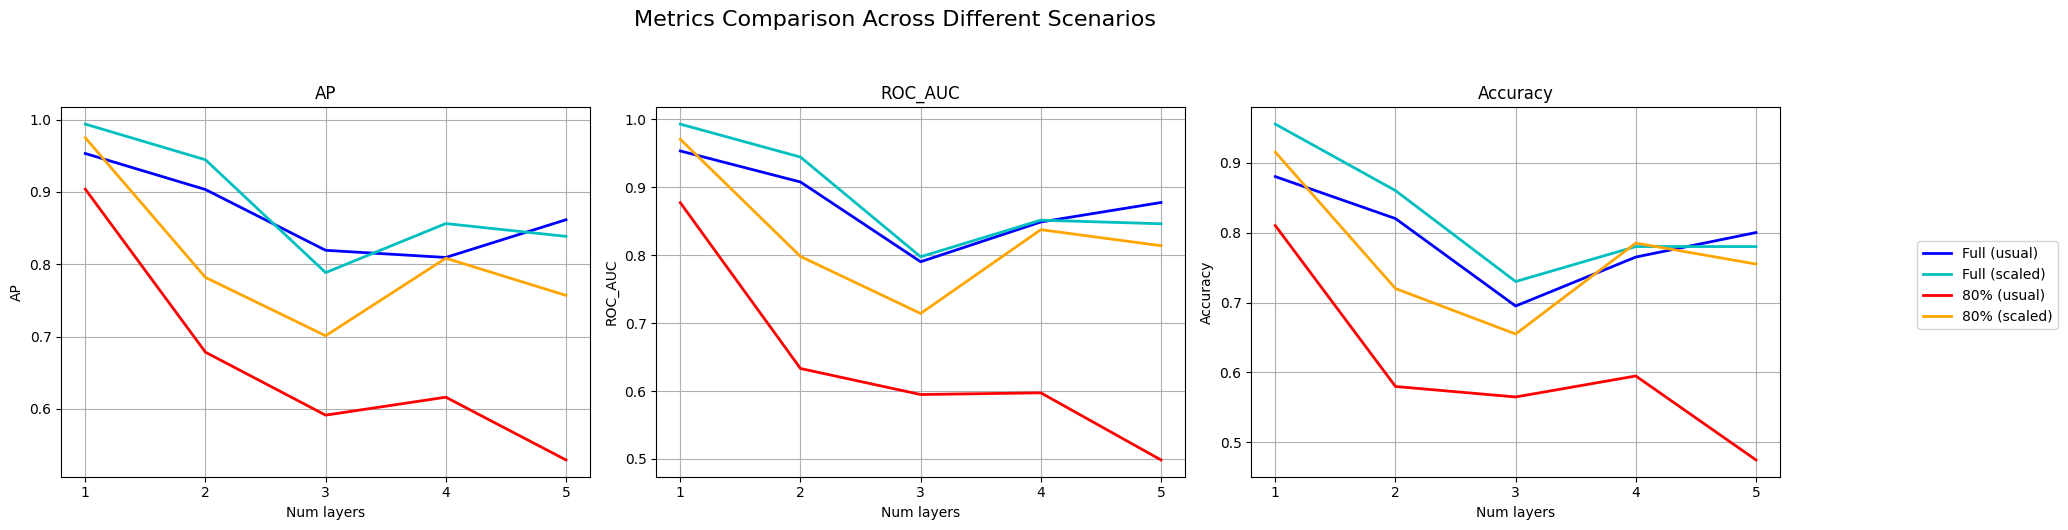

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics():
    x = [1, 2, 3, 4, 5]

    # Данные для каждого варианта
    data = {
        'Full (usual)': {
            'AP': [0.9530406340291837, 0.9032055844221218, 0.8192206017947433, 0.8093505556238254, 0.8614786759205879],
            'ROC_AUC': [0.9535, 0.9078, 0.7904, 0.8489, 0.8776],
            'Accuracy': [0.88, 0.82, 0.695, 0.765, 0.8]
        },
        'Full (scaled)': {
            'AP': [0.9936250395163475, 0.9443559428152941, 0.7883964396250562, 0.856205561601022, 0.8384889357838595],
            'ROC_AUC': [0.9930, 0.9445, 0.7977, 0.8516, 0.8463],
            'Accuracy': [0.955, 0.86, 0.73, 0.78, 0.78]
        },
        '80% (usual)': {
            'AP': [0.9037569828107275, 0.6783645118877479, 0.5913822757421682, 0.6162000544808414, 0.5294834576896381],
            'ROC_AUC': [0.8773, 0.6332, 0.5949, 0.5974, 0.4986],
            'Accuracy': [0.81, 0.58, 0.565, 0.595, 0.475]
        },
        '80% (scaled)': {
            'AP': [0.9747609403212167, 0.7817200083446949, 0.7011099462076036, 0.8082838497791751, 0.7569467865099042],
            'ROC_AUC': [0.9707, 0.7982, 0.7142, 0.8376, 0.8140],
            'Accuracy': [0.915, 0.72, 0.655, 0.785, 0.755]
        }
    }

    metrics = ['AP', 'ROC_AUC', 'Accuracy']
    colors = ['b', 'c', 'r', 'orange']  # Цвета для разных вариантов

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Metrics Comparison Across Different Scenarios', fontsize=16, y=1.05)

    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.set_title(metric)
        ax.set_xlabel('Num layers')
        ax.set_ylabel(metric)
        ax.set_xticks(x)
        ax.grid(True)

        # Рисуем линии для каждого варианта
        for j, (label, values) in enumerate(data.items()):
            ax.plot(x, values[metric], color=colors[j], label=label, linestyle='-', linewidth=2)

    # Общая легенда справа от графиков
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5))

    plt.tight_layout()
    plt.show()

    # # Создаем отдельный график для каждой метрики
    # for metric in metrics:
    #     plt.figure(figsize=(10, 6))
    #     plt.title(f'{metric} comparison')
    #     plt.xlabel('Num layers')
    #     plt.ylabel(metric)
    #     plt.xticks(x)
    #     plt.grid(True)

    #     # Рисуем линии для каждого варианта
    #     for i, (label, values) in enumerate(data.items()):
    #         plt.plot(x, values[metric], marker='o', color=colors[i], label=label)

    #     plt.legend()
    #     plt.show()

# Вызов функции для построения графиков
plot_metrics()

### Proportion 0.8

Full (usual):
- AP: [0.9032055844221218, 0.8192206017947433, 0.8093505556238254, 0.8614786759205879]
- ROC_AUC: [0.9078, 0.7904, 0.8489, 0.8776]
- Accuracy: [0.82, 0.695, 0.765, 0.8]

Full (scaled):
- AP: [0.9443559428152941, 0.7883964396250562, 0.856205561601022, 0.8384889357838595]
- ROC_AUC: [0.9445, 0.7977, 0.8516, 0.8463]
- Accuracy: [0.86, 0.73, 0.78, 0.78]

80% (usual):
- AP: [0.6783645118877479, 0.5913822757421682, 0.6162000544808414, 0.5294834576896381]
- ROC_AUC: [0.6332, 0.5949, 0.5974, 0.4986]
- Accuracy: [0.58, 0.565, 0.595, 0.475]

80% (scaled):
- AP: [0.7817200083446949, 0.7011099462076036, 0.8082838497791751, 0.7569467865099042]
- ROC_AUC: [0.7982, 0.7142, 0.8376, 0.8140]
- Accuracy: [0.72, 0.655, 0.785, 0.755]

Объясненная дисперсия по каждому компоненту: [0.42598778 0.1750244 ]
Суммарная объясненная дисперсия: 0.6010122


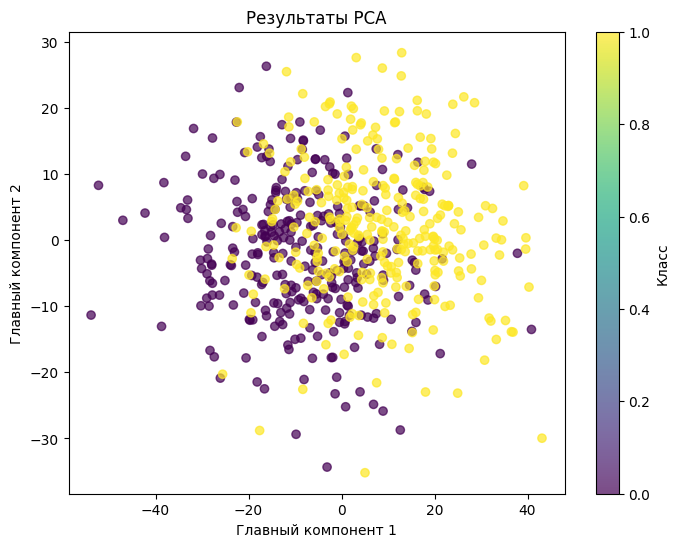

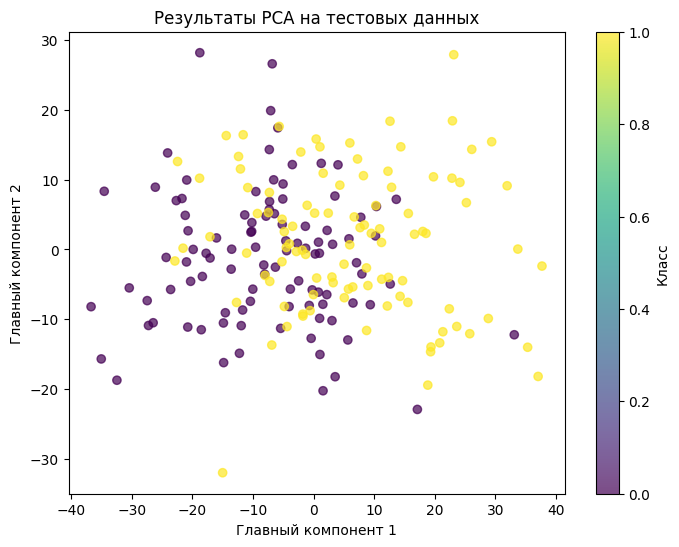

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Предположим, у вас есть данные в массиве NumPy `X`.
# Для примера сгенерируем случайные данные:
# X = np.random.rand(100, 50) # 100 образцов, 50 признаков

# Объедините ваши векторы для обучения и тестирования
X_train = np.vstack((vectors_1, vectors_2))
X_test = np.vstack((vectors_1_test, vectors_2_test))
y_train = np.array([0] * len(vectors_1) + [1] * len(vectors_2))
y_test = np.array([0] * len(vectors_1_test) + [1] * len(vectors_2_test))


# 1. Стандартизация данных
# PCA чувствителен к масштабу признаков, поэтому рекомендуется стандартизовать данные.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)  # Выберем 2 компонента для визуализации

# Обучите PCA на стандартизованных обучающих данных и примените преобразование
X_train_pca = pca.fit_transform(X_train_scaled)

# Примените то же преобразование к тестовым данным
X_test_pca = pca.transform(X_test_scaled)

# 3. Анализ результатов
print("Объясненная дисперсия по каждому компоненту:", pca.explained_variance_ratio_)
print("Суммарная объясненная дисперсия:", np.sum(pca.explained_variance_ratio_))

# 4. Визуализация результатов (для 2 или 3 компонентов)
if pca.n_components == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
    plt.xlabel('Главный компонент 1')
    plt.ylabel('Главный компонент 2')
    plt.title('Результаты PCA')
    plt.colorbar(label='Класс')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7)
    plt.xlabel('Главный компонент 1')
    plt.ylabel('Главный компонент 2')
    plt.title('Результаты PCA на тестовых данных')
    plt.colorbar(label='Класс')
    plt.show()

Usual:

- AP: 0.9515088597188532
- ROC_AUC: 0.9495
- Accuracy: 0.88

- AP: 0.9294073036808659
- ROC_AUC: 0.9209
- Accuracy: 0.855

Scaled:

- AP: 0.9598035921545534
- ROC_AUC: 0.965
- Accuracy: 0.9

- AP: 0.8584159242397562
- ROC_AUC: 0.841
- Accuracy: 0.755